### 程序目标：获取特定刊物的文章标题，查看刊物的聚焦点（以`TVCG`在最近28年的文章为例）
1. 获取TVCG自1995年~2022年（共28年）的所有文章标题
2. 存放到MongoDB数据库中，基础字段为（year, title)
3. 依次将title进行分词
 * ① 直接切分，同时去除停用词与标点符号，并将分词结果放在对应记录的新字段下（新字段名：afterCutting）
 * `②` 考虑部分词经常一起出现，例如（'Data', 'Visualization')，所以直接切分会把一些组合词切开，无法获取隐藏的信息价值，所以，在①的基础上，`失败的尝试`一开始采用的方法是将某年的所有标题分割出来的词，进行排列组合，将组合结果加入过滤词表，但是最后发现了问题：每一篇文章标题的词也会进行排列组合，导致最后所有标题都会有组合词存在。`二次尝试`统计词频，将每年的词频大于1的词（也就是当年的文章标题中出现过至少2次及以上的次）进行组合，然后以此为组合词，进一步切分每个标题，获取的结果存入新字段下（新字段名：afterCutting_selfDefine）
4. 按年统计词频，绘图，观察
5. 获取全年词频，绘图，观察
6. 统计全28年的文章标题并输出，同时基于文章数绘制数量走势图

## 1
### 简单的数据爬取函数
* 爬取论文的标题（需要修改的地方，后面做了标记：`●`）

* 1990-2005: visualization
* `2006-2018: ieeevast`
* 2019-2021: visualization

In [1]:
import requests
from bs4 import BeautifulSoup

def get_pages_within_vis(startYear, endYear):
    SimpleInfo = list()
    for year in range(startYear, endYear + 1):
        wb_data = requests.get('https://dblp.uni-trier.de/db/conf/visualization/visualization{}.html'.format(year))  # ●
        soup = BeautifulSoup(wb_data.text, 'lxml')
        titles = soup.select('cite > span.title')
        for title in titles:
            data = {
                'year': year,
                'title': title.get_text()
            }
            SimpleInfo.append(data)

    return SimpleInfo

In [2]:
import requests
from bs4 import BeautifulSoup

def get_pages_within_vast(startYear, endYear):
    SimpleInfo = list()
    for year in range(startYear, endYear + 1):
        wb_data = requests.get('https://dblp.uni-trier.de/db/conf/ieeevast/ieeevast{}.html'.format(year))  # ●
        soup = BeautifulSoup(wb_data.text, 'lxml')
        titles = soup.select('cite > span.title')
        for title in titles:
            data = {
                'year': year,
                'title': title.get_text()
            }
            SimpleInfo.append(data)

    return SimpleInfo

### 首先获取去除停用词和标点符号之后的词组
* 函数名为：`sentencesCutting_1`
* 入口参数：`sent` : 待切割的句子（这里是文章的title）

In [3]:
import nltk
from nltk.corpus import stopwords

def sentencesCutting_Init(sent):
    interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '"']   # 定义符号列表
    stops = set(stopwords.words("english"))
    
    cutInit = nltk.word_tokenize(sent)  # 初始分词结果
    # print("cutInit: %s" % cutInit)

    # 去除标点符号和停用词
    cutPun8Sw = [word for word in cutInit if (word not in interpunctuations and word not in stops)]   # 去除标点符号

    return cutPun8Sw

In [4]:
# 获取28年每年的论文标题，Volume 1, 1995 -- Volume 28, 2022
startYear_vis = 1990
endYear_vis = 2021
SimpleInfo_vis = get_pages_within_vis(startYear_vis, endYear_vis) 
print(f"IEEE VIS从{startYear_vis}年到{endYear_vis}年，这{endYear_vis-startYear_vis + 1}年总共有IEEE VIS论文{len(SimpleInfo_vis)}篇。")

IEEE VIS从1990年到2021年，这32年总共有IEEE VIS论文1365篇。


### 画出来看看IEEE VIS的论文数

{1990: 55, 1991: 51, 1992: 54, 1993: 56, 1994: 66, 1995: 57, 1996: 73, 1997: 78, 1998: 79, 1999: 75, 2000: 77, 2001: 75, 2002: 79, 2003: 81, 2004: 112, 2005: 135, 2006: 0, 2007: 0, 2008: 0, 2009: 0, 2010: 0, 2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, 2018: 0, 2019: 60, 2020: 60, 2021: 42}


Text(0.5, 1.0, '全32年论文数量图')

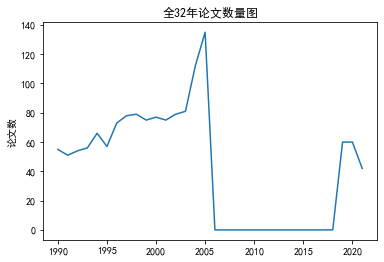

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


vis_num = dict()
startYear_vis = 1990
endYear_vis = 2021
for each in SimpleInfo_vis:
    year = each['year']
    vis_num[year] = vis_num.get(year, 0) + 1
    
plotDict = dict()
for year in range(startYear_vis, endYear_vis + 1):
    if year in vis_num.keys():
        plotDict[year] = vis_num[year]
    else:
        plotDict[year] = 0
        
print(plotDict)

x1 = list(plotDict.keys())
y1 = list(plotDict.values())
plt.plot(x1, y1)
# plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('论文数')
plt.title(f'全{endYear_vis-startYear_vis + 1}年论文数量图')

In [7]:
# 获取28年每年的论文标题，Volume 1, 1995 -- Volume 28, 2022
startYear_vast = 1990
endYear_vast = 2021
SimpleInfo_vast = get_pages_within_vast(startYear_vast, endYear_vast) 
print(f"IEEE VIS从{startYear_vast}年到{endYear_vast}年，这{endYear_vast-startYear_vast + 1}年总共有IEEE VIS论文{len(SimpleInfo_vast)}篇。")

IEEE VIS从1990年到2021年，这32年总共有IEEE VIS论文710篇。


### 画出来看看IEEE VAST的论文数

{1990: 0, 1991: 0, 1992: 0, 1993: 0, 1994: 0, 1995: 0, 1996: 0, 1997: 0, 1998: 0, 1999: 0, 2000: 0, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 30, 2007: 49, 2008: 47, 2009: 61, 2010: 65, 2011: 60, 2012: 70, 2013: 0, 2014: 108, 2015: 69, 2016: 20, 2017: 55, 2018: 30, 2019: 35, 2020: 11, 2021: 0}


Text(0.5, 1.0, '全32年论文数量图')

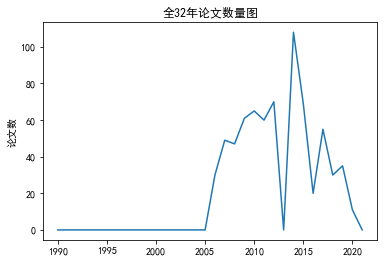

In [9]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

vast_num = dict()
startYear_vast = 1990
endYear_vast = 2021
for each in SimpleInfo_vast:
    year = each['year']
    vast_num[year] = vast_num.get(year, 0) + 1
    
plotDict = dict()
for year in range(startYear_vast, endYear_vast + 1):
    if year in vast_num.keys():
        plotDict[year] = vast_num[year]
    else:
        plotDict[year] = 0
        
print(plotDict)

x1 = list(plotDict.keys())
y1 = list(plotDict.values())
plt.plot(x1, y1)
# plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('论文数')
plt.title(f'全{endYear_vast-startYear_vast + 1}年论文数量图')

In [10]:
SimpleInfo = SimpleInfo_vis + SimpleInfo_vast

In [11]:
print(type(SimpleInfo))

<class 'list'>


[{'year': 1990, 'title': '1st IEEE Visualization Conference, IEEE Vis 1990, San Francisco, CA, USA, October 23-26, 1990, Proceedings.'}, {'year': 1990, 'title': 'Surface Representations of Two- and Three-Dimensional Fluid Flow Topology.'}, {'year': 1990, 'title': 'FAST: A Multi-Processed Environment for Visualization of Computational Fluid Dynamics.'}]
从1990年到2021年，这32年总共有IEEE VIS论文2075篇。
{1990: 55, 1991: 51, 1992: 54, 1993: 56, 1994: 66, 1995: 57, 1996: 73, 1997: 78, 1998: 79, 1999: 75, 2000: 77, 2001: 75, 2002: 79, 2003: 81, 2004: 112, 2005: 135, 2006: 30, 2007: 49, 2008: 47, 2009: 61, 2010: 65, 2011: 60, 2012: 70, 2013: 0, 2014: 108, 2015: 69, 2016: 20, 2017: 55, 2018: 30, 2019: 95, 2020: 71, 2021: 42}


Text(0.5, 1.0, '全32年论文数量图')

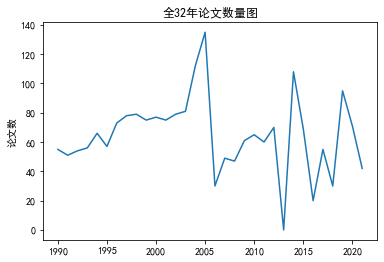

In [12]:
startYear = 1990
endYear = 2021
print(SimpleInfo[0:3])
print(f"从{startYear}年到{endYear}年，这{endYear-startYear + 1}年总共有IEEE VIS论文{len(SimpleInfo)}篇。")


import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

all_num = dict()

for each in SimpleInfo:
    year = each['year']
    all_num[year] = all_num.get(year, 0) + 1
    
plotDict = dict()
for year in range(startYear, endYear + 1):
    if year in all_num.keys():
        plotDict[year] = all_num[year]
    else:
        plotDict[year] = 0
        
print(plotDict)

x1 = list(plotDict.keys())
y1 = list(plotDict.values())
plt.plot(x1, y1)
# plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('论文数')
plt.title(f'全{endYear-startYear + 1}年论文数量图')

### 小函数集锦（保存、加载变量）

In [13]:
import pickle
# Input: 变量名，保存路径
# Output: 保存路径
def save_variable1(v, filename):
    f = open(filename, 'wb')
    pickle.dump(v, f, 0)  # 在dump()里加上第三个参数，设为0(ASCII协议).
    f.close()
    return filename

# Input: 保存的变量路径
# Output: 变量
def load_variable1(filename):
    f = open(filename, 'rb')
    r = pickle.load(f)
    f.close()
    return r

def save_variable2(v, filename):
    try: 
        # f = open('test001.txt','w',encoding='utf-8') #open 打开要写入的文件，'w'就是写入的意思，如果有中文encoding进行编码
        with open(filename,'w',encoding='utf-8') as f:
            f.write(v)  # write是写入的意思，将（）中的内容写入到f文件里
            
    # 无论try中的程序是否存在报错，则都执行下面的关闭
    finally: 
        if f:  # 判断下f是否打开了，如果没打开则不需要关闭，打开了则关闭
            f.close()
    return filename

def load_variable2(filename):
    # 首先try一下，如果程序打开以及在打开后读取一系列操作后有报错，则不中断程序
    try:  
        # f = open(filename, 'r', encoding='utf-8')
        with open(filename, 'r', encoding='utf-8') as f:
            strContent = f.read()
    # 无论try中的程序是否存在报错，则都执行下面的关闭
    finally:  
        if f:  # 判断下f是否打开了，如果没打开则不需要关闭，打开了则关闭
            f.close()
    return strContent

In [14]:
save_variable1(SimpleInfo, 'IEEEV_32years_withType.txt')

'IEEEV_32years_withType.txt'

In [15]:
save_variable2(str(SimpleInfo), 'IEEEV_32years_withoutType.txt')

'IEEEV_32years_withoutType.txt'

### 数据库、集合的删除相关操作

```python
# 删除指定数据库
exec("db.drop_database('" + targetDB + "')")  # db.drop_database('db_tvcg_28years')

# 删除目标集合内的指定字段
exec(targetCol + ".update_many({}, {'unset': {'testFields': ''}})")

# 删除目标集合内所有的文档
exec(targetCol + ".delete_many({})")
```

## 2
### 1/2 在新的数据库的新的集合内，插入爬取得到的`title`，同时新建一个`字段`，存放初始的分割结果

In [16]:
# 将爬取的数据，存到目标集合targetCol中
def saveData2Collection(SimpleInfo, targetCol, newField):
    # 操作对应的集合
    exec(targetCol + ".insert_many(SimpleInfo)")
    
    exec("exists = " + targetCol + ".find_one({'" + newField + "': {'$exists': True}})")
    loc = locals()
    if not loc['exists']:
        print("不存在，可新增！正在新建...")
        exec("recs = " + targetCol + ".find()")
        for c in loc['recs']: 
            exec(targetCol + ".update_one({'_id': c['_id']}, {'$set': {'" + newField + "': list()}})")
        print(targetCol + ": 新建完成！")
    else:
        print("已存在，无法新增！")    

### 2/2 分割文章的`title`放入新字段中

In [17]:
# 将目标集合targetCol中的字段分割，并且放到新字段里
def cutTitle2Fields(targetCol, newField):
    # 分词结束，这段代码就不执行了！
    exec("recs = " + targetCol + ".find()")
    loc = locals()
    for c in loc['recs']: 
        id = c['_id']
        title = c['title']
        cutTitle = sentencesCutting_Init(title) 
        if not c.get(newField):
            exec(targetCol + ".update_one({'_id': id}, {'$set': {'" + newField + "': cutTitle}})")

    print("Done!")

In [ ]:
# 第二天重启jupyter notebook之后，前一天执行的所有变量都没了，所以需要重新连接一下数据库
import pymongo

db = pymongo.MongoClient("mongodb://localhost:27017/")

# 目标数据库
targetDB = 'db_tvcg_28years'
targetCol = 'col_tvcg_28years'

exec(targetDB + " = db['" + targetDB + "']")  # db_tvcg_28years = db["db_tvcg_28years"]
exec(targetCol + " = " + targetDB + "['" + targetCol + "']")  # col_tvcg_28years = db_tvcg_28years["col_tvcg_28years"] 

exec("tempCnt = " + targetCol + ".count_documents({})")
exec("print(f'当前数据库共有记录{tempCnt}条')")

## 3-①

In [18]:
import pymongo
import sys

if __name__ == '__main__':
    
    db = pymongo.MongoClient("mongodb://localhost:27017/")

    # 目标数据库（没有则新建） ●
    targetDB = 'db_IEEEVIS_28years'
    targetCol = 'col_IEEEVIS_28years'
    
    # 避免重复，先删除掉已有的数据库
    exec("db.drop_database('" + targetDB + "')")  # db.drop_database('db_tvcg_28years')
    
    
    print(f"执行前所有数据库为：{db.list_database_names()}")
    exec(targetDB + " = db['" + targetDB + "']")  # db_tvcg_28years = db["db_tvcg_28years"]
    exec(targetCol + " = " + targetDB + "['" + targetCol + "']")  # col_tvcg_28years = db_tvcg_28years["col_tvcg_28years"] 

    
    print("--------------------------------------1/2")
    print("开始插入数据，并新建字段")
    
    newField = 'afterCutting'
    
    saveData2Collection(SimpleInfo, targetCol, newField)
    
    print("--------------------------------------2/2")
    print("开始对标题title进行分割")
    
    cutTitle2Fields(targetCol, newField)
    
    print(f"执行后所有数据库为：{db.list_database_names()}")

执行前所有数据库为：['admin', 'config', 'db_Weibo_SH0331', 'db_Weibo_SH_0331_All', 'db_tvcg3years', 'db_tvcg4years', 'db_tvcgR3', 'db_tvcg_28years', 'db_weiboDB', 'local', 'test', 'weiboInfoAll']
--------------------------------------1/2
开始插入数据，并新建字段
不存在，可新增！正在新建...
col_IEEEVIS_28years: 新建完成！
--------------------------------------2/2
开始对标题title进行分割
Done!
执行后所有数据库为：['admin', 'config', 'db_IEEEVIS_28years', 'db_Weibo_SH0331', 'db_Weibo_SH_0331_All', 'db_tvcg3years', 'db_tvcg4years', 'db_tvcgR3', 'db_tvcg_28years', 'db_weiboDB', 'local', 'test', 'weiboInfoAll']


#### 获取每年的`文章数`，和每年文章标题切分后得到的`所有分词`
`{1995: [titleNums, ['words1', 'words2', 'words3', ...]]}`

In [19]:
# 获取指定集合下指定字段
def getWordsbyYears(targetCol, newField, startYear, endYear):
    dictWords = {}
    
    loc = locals()
    for year in range(startYear, endYear + 1):
        tempWords = list()
        queryCondition = {"year": year}
        exec("recs = " + targetCol + ".find(queryCondition)")
        for cW in loc['recs']: 
            # 多个list合并为一个list
            tempWords = tempWords + cW.get(newField)  # 把指定年份的所有从标题分割出的词，放在一个list里

        exec("tempCnt = " + targetCol + ".count_documents(queryCondition)")  # 获取指定年份的所有标题数量
        dictWords[year] = [loc['tempCnt'], tempWords]
        
    return dictWords  # 返回一个字典，字典的key是年份，value是对应年份的文章数 & 分割词的总和

In [20]:
startYear = 1990
endYear = 2021
newField = 'afterCutting'

# dictWords拿到的是1995-2022年所有的数据
dictWords = getWordsbyYears(targetCol, newField, startYear, endYear)

# 打印1995年的数据出来看看(1995是key)
print(dictWords[1990])  # 输出的value是一个列表，列表第一个是数字，表示1995年发表了32篇文章，数字后面的列表是当年文章标题所有单词总和

[55, ['1st', 'IEEE', 'Visualization', 'Conference', 'IEEE', 'Vis', '1990', 'San', 'Francisco', 'CA', 'USA', 'October', '23-26', '1990', 'Proceedings', 'Surface', 'Representations', 'Two-', 'Three-Dimensional', 'Fluid', 'Flow', 'Topology', 'FAST', 'A', 'Multi-Processed', 'Environment', 'Visualization', 'Computational', 'Fluid', 'Dynamics', 'The', 'VIS-5D', 'System', 'Easy', 'Interactive', 'Visualization', 'A', 'Procedural', 'Interface', 'Volume', 'Rendering', 'Techniques', 'Interactive', 'Visualization', 'Volumetric', 'Data', 'Displaying', 'Voxel-Based', 'Objects', 'According', 'Their', 'Qualitative', 'Shape', 'Synthesis', 'Interpreting', '3D', 'Object', 'Rough', '2D', 'Line', 'Drawing', 'Animation', 'Techniques', 'Chain-Coded', 'Objects', 'Extracting', 'Geometric', 'Models', 'Through', 'Constraint', 'Minimization', 'Wide-band', 'Relativistic', 'Doppler', 'Effect', 'Visualization', 'Dynamic', 'Graphics', 'Network', 'Visualization', 'Techniques', 'Visualizing', 'Fermat', "'s", 'Last', 'T

#### 预览函数
* 查看指定年份的前`x%`, 例如`10%`的词

In [21]:
# 这个函数只用来查看，不用来修改任何值
def viewData(dictWords, year, per = 1.0):
    # 取某年的词频在前80%（默认）的词，查看→[词 - 词频]
    freqWords = dict()
    for eachWord in dictWords[year][1]:
        freqWords[eachWord] = freqWords.get(eachWord, 0) + 1

    items = list(freqWords.items())  # 转换为list
    print("items.len = " + str(len(items)))
    items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序
    
    topK = int(len(items) * per)  # 获取词频排在前100%的分词(如果per = 0.8，就是80%的分词)
    print("topK = %d" % topK)
    
    # 按照指定格式显示词 & 词频
    print("-----------------------------------")
    for i in range(topK):
        word, count = items[i]
        print("{0:<20}{1:>10}".format(word, count))
        
    
    reIndexDict = dict()
    for i in range(topK):
        word, count = items[i]
        # 重要代码 1：逆向索引，存储出现固定次数的词语。比如出现8次的词语有['a', 'b', 'c'], 就存为：{8: ['a', 'b', 'c']}
        reIndexDict.setdefault(count, list())
        reIndexDict[count].append(word)
    
    return reIndexDict

In [22]:
reIndexDict = viewData(dictWords, 1990, 0.5)  # 看一下1995年的最热的top 50%的标题词

items.len = 228
topK = 114
-----------------------------------
Visualization               26
A                           11
Data                         9
Techniques                   7
System                       6
Visualizing                  5
Interactive                  4
Volume                       4
Rendering                    4
Scalar                       4
Representations              3
Three-Dimensional            3
Fluid                        3
Environment                  3
Objects                      3
3D                           3
Research                     3
Display                      3
Applications                 3
IEEE                         2
1990                         2
Surface                      2
The                          2
Interface                    2
Shape                        2
Geometric                    2
Models                       2
Scientific                   2
Spherical                    2
Sets                         2
Microco

In [23]:
print(reIndexDict[4])

# 输出倒序索引的结果，后续处理的就是词频>=2的所有词的组合
for key, value in reIndexDict.items():
    print(f"{key}: {value}")

['Interactive', 'Volume', 'Rendering', 'Scalar']
26: ['Visualization']
11: ['A']
9: ['Data']
7: ['Techniques']
6: ['System']
5: ['Visualizing']
4: ['Interactive', 'Volume', 'Rendering', 'Scalar']
3: ['Representations', 'Three-Dimensional', 'Fluid', 'Environment', 'Objects', '3D', 'Research', 'Display', 'Applications']
2: ['IEEE', '1990', 'Surface', 'The', 'Interface', 'Shape', 'Geometric', 'Models', 'Scientific', 'Spherical', 'Sets', 'Microcomputer', 'Fields', 'Engineering']
1: ['1st', 'Conference', 'Vis', 'San', 'Francisco', 'CA', 'USA', 'October', '23-26', 'Proceedings', 'Two-', 'Flow', 'Topology', 'FAST', 'Multi-Processed', 'Computational', 'Dynamics', 'VIS-5D', 'Easy', 'Procedural', 'Volumetric', 'Displaying', 'Voxel-Based', 'According', 'Their', 'Qualitative', 'Synthesis', 'Interpreting', 'Object', 'Rough', '2D', 'Line', 'Drawing', 'Animation', 'Chain-Coded', 'Extracting', 'Through', 'Constraint', 'Minimization', 'Wide-band', 'Relativistic', 'Doppler', 'Effect', 'Dynamic', 'Graphi

#### 人工检查部分，可以不理会

In [24]:
# 从数据库中把1995年的文章标题提取出来，看看统计的对不对（人工检验一下）
queryCondition = {"year": 1990}
exec("res = " + targetCol + ".find(queryCondition)")
print(res)
findStr = 'Visualization'
cnt = 0
for r in res: 
    title = r.get('title')
    if findStr in title:
        cnt = cnt + 1
    print(title)

print("==================")
print(f"你没算错，{findStr}出现了{cnt}次")

1st IEEE Visualization Conference, IEEE Vis 1990, San Francisco, CA, USA, October 23-26, 1990, Proceedings.
Surface Representations of Two- and Three-Dimensional Fluid Flow Topology.
FAST: A Multi-Processed Environment for Visualization of Computational Fluid Dynamics.
The VIS-5D System for Easy Interactive Visualization.
A Procedural Interface for Volume Rendering.
Techniques for the Interactive Visualization of Volumetric Data.
Displaying Voxel-Based Objects According to Their Qualitative Shape Synthesis.
Interpreting a 3D Object from a Rough 2D Line Drawing.
Animation Techniques for Chain-Coded Objects.
Extracting Geometric Models Through Constraint Minimization.
Wide-band Relativistic Doppler Effect Visualization.
Dynamic Graphics for Network Visualization.
Techniques for Visualizing Fermat's Last Theorem.
Visualizing Computer Memory Architectures.
A Methodology for Scientific Visualization: Choosing Representations based on Natural Scene Paradigm.
Moving Iconic Objects in Scientif

## 3-②
### Code 1 ~ Code7
### 依次获取`每年`的`相同频率的关键词，进行排列组合`，形成词组，放到字典中，如下形式：
```python
{1995:  
    {
        8: ['Visualization'], 
        5: ['Volume'], 
        4: ['Rendering', 'Using', 'A'], 
        3: ['Animation', 'Data', 'Flow']
    }
}

↓↓↓↓↓↓↓↓↓↓

[('Rendering', 'Using'), ('Rendering', 'A'), ('Using', 'Rendering'), ('Using', 'A'), ('A', 'Rendering'), ('A', 'Using'), ('Animation', 'Data'), ('Animation', 'Flow'), ('Data', 'Animation'),...]
```

### Code 1

In [25]:
def getFreq_AllYears(dictWords, startYear, endYear, per = 1.0):
    
    Freq_AllYears = dict()
    for year in range(startYear, endYear + 1):
        freqWords = dict()
        for eachWord in dictWords[year][1]:
            freqWords[eachWord] = freqWords.get(eachWord, 0) + 1
            
        items = list(freqWords.items())  # 转换为list
        print(f"{year}: items.len = " + str(len(items)))
        items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序

        topK = int(len(items) * per)  # 获取词频排在前100%的分词(默认就是所有词)
        print("topK = %d" % topK)
        
        reIndexDict = dict()  # ▲

        for i in range(topK):
            word, count = items[i]        
            # 重要代码 1
            reIndexDict.setdefault(count, list())  # ▲
            reIndexDict[count].append(word)  # ▲

        Freq_AllYears[year] = reIndexDict
    
    return Freq_AllYears


### Code 2

In [26]:
Freq_AllYears = getFreq_AllYears(dictWords, 1990, 2021, per = 1.0)

1990: items.len = 228
topK = 228
1991: items.len = 229
topK = 229
1992: items.len = 206
topK = 206
1993: items.len = 230
topK = 230
1994: items.len = 282
topK = 282
1995: items.len = 246
topK = 246
1996: items.len = 324
topK = 324
1997: items.len = 346
topK = 346
1998: items.len = 351
topK = 351
1999: items.len = 343
topK = 343
2000: items.len = 353
topK = 353
2001: items.len = 321
topK = 321
2002: items.len = 347
topK = 347
2003: items.len = 351
topK = 351
2004: items.len = 475
topK = 475
2005: items.len = 502
topK = 502
2006: items.len = 150
topK = 150
2007: items.len = 209
topK = 209
2008: items.len = 241
topK = 241
2009: items.len = 302
topK = 302
2010: items.len = 367
topK = 367
2011: items.len = 302
topK = 302
2012: items.len = 355
topK = 355
2013: items.len = 0
topK = 0
2014: items.len = 483
topK = 483
2015: items.len = 295
topK = 295
2016: items.len = 119
topK = 119
2017: items.len = 264
topK = 264
2018: items.len = 182
topK = 182
2019: items.len = 472
topK = 472
2020: items.le

### Code 3

In [27]:
# print(Freq_AllYears[1995])
for key, value in Freq_AllYears[1990].items():
    print(f"{key}: {value}")


26: ['Visualization']
11: ['A']
9: ['Data']
7: ['Techniques']
6: ['System']
5: ['Visualizing']
4: ['Interactive', 'Volume', 'Rendering', 'Scalar']
3: ['Representations', 'Three-Dimensional', 'Fluid', 'Environment', 'Objects', '3D', 'Research', 'Display', 'Applications']
2: ['IEEE', '1990', 'Surface', 'The', 'Interface', 'Shape', 'Geometric', 'Models', 'Scientific', 'Spherical', 'Sets', 'Microcomputer', 'Fields', 'Engineering']
1: ['1st', 'Conference', 'Vis', 'San', 'Francisco', 'CA', 'USA', 'October', '23-26', 'Proceedings', 'Two-', 'Flow', 'Topology', 'FAST', 'Multi-Processed', 'Computational', 'Dynamics', 'VIS-5D', 'Easy', 'Procedural', 'Volumetric', 'Displaying', 'Voxel-Based', 'According', 'Their', 'Qualitative', 'Synthesis', 'Interpreting', 'Object', 'Rough', '2D', 'Line', 'Drawing', 'Animation', 'Chain-Coded', 'Extracting', 'Through', 'Constraint', 'Minimization', 'Wide-band', 'Relativistic', 'Doppler', 'Effect', 'Dynamic', 'Graphics', 'Network', 'Fermat', "'s", 'Last', 'Theorem'

### Code 4

In [28]:
from itertools import permutations

print(Freq_AllYears[1990].keys())  # dict_keys([8, 5, 4, 3, 2, 1])

'''
词频依次为：8, 5, 4, 3, 2, 1
对应的词数为：1, 1, 3, 3, 9, xxxx
得到的组合词数量是：0, 0, 3*2, 3*2, 9*8 (累加起来：84)
8: ['Visualization']
5: ['Volume']
4: ['Rendering', 'Using', 'A']
3: ['Animation', 'Data', 'Flow']
2: ['Visualizing', '3D', 'An', 'Global', 'Illumination', 'Multiscale', 'Line', 'Unsteady', 'System']
1: ['Editorials', 'Real', 'Time', 'Responsive', 'Personality', 'Network',...]
'''
def generateInitPhrases_v2(Freq_AllYears, startYear, endYear):
    
    permut_AllYears = dict()
    
    for year in range(startYear, endYear + 1):
        tempMwe = list()
        for k, v in Freq_AllYears[year].items():
            if k > 1:
#                 print(len(v))
                for p in permutations(v, 2):
                    tempMwe.append(p)
        
        permut_AllYears[year] = tempMwe

    return permut_AllYears

dict_keys([26, 11, 9, 7, 6, 5, 4, 3, 2, 1])


### Code 5

In [29]:
# 小单元测试
testRes = generateInitPhrases_v2(Freq_AllYears, 1990, 1990)
print(testRes[1990])
print(len(testRes[1990]))

[('Interactive', 'Volume'), ('Interactive', 'Rendering'), ('Interactive', 'Scalar'), ('Volume', 'Interactive'), ('Volume', 'Rendering'), ('Volume', 'Scalar'), ('Rendering', 'Interactive'), ('Rendering', 'Volume'), ('Rendering', 'Scalar'), ('Scalar', 'Interactive'), ('Scalar', 'Volume'), ('Scalar', 'Rendering'), ('Representations', 'Three-Dimensional'), ('Representations', 'Fluid'), ('Representations', 'Environment'), ('Representations', 'Objects'), ('Representations', '3D'), ('Representations', 'Research'), ('Representations', 'Display'), ('Representations', 'Applications'), ('Three-Dimensional', 'Representations'), ('Three-Dimensional', 'Fluid'), ('Three-Dimensional', 'Environment'), ('Three-Dimensional', 'Objects'), ('Three-Dimensional', '3D'), ('Three-Dimensional', 'Research'), ('Three-Dimensional', 'Display'), ('Three-Dimensional', 'Applications'), ('Fluid', 'Representations'), ('Fluid', 'Three-Dimensional'), ('Fluid', 'Environment'), ('Fluid', 'Objects'), ('Fluid', '3D'), ('Fluid'

In [ ]:
# deprecated 弃用
import sys
from itertools import permutations

def generateInitPhrases(Freq_AllYears, startYear, endYear):
    
    sys.exit()
    permut_AllYears = dict()
    
    for year in range(startYear, endYear + 1):
        tempMwe = list()
        for p in permutations(Freq_AllYears[year].keys(), 2):
            tempMwe.append(p)
            
        permut_AllYears[year] = tempMwe

    return permut_AllYears

### Code 6

In [30]:
permut_AllYears = generateInitPhrases_v2(Freq_AllYears, 1990, 2021)

### Code 7

In [31]:
print(permut_AllYears[1990][0:3])
print(permut_AllYears[1991][0:3])
print("...")
print(permut_AllYears[2021][0:3])

[('Interactive', 'Volume'), ('Interactive', 'Rendering'), ('Interactive', 'Scalar')]
[('Visualizing', 'The'), ('The', 'Visualizing'), ('Volume', 'Scientific')]
...
[('A', 'Data'), ('A', 'Analytics'), ('Data', 'A')]


### Code 8 ~ Code 11
### 下面的代码，看看组合词的情况，并且把组合词合并起来
 *Have a look*. 看一下每年的组合词的数量以及28年总共产生的组合词的数量（不一定每个组合词都是存在的）

### Code 8

In [34]:
print("每年词频大于1的词，组成的词组，数量依次为：")
print("==========================")
cnt = 0
for i in range(1990, 2021 + 1):
    print(f"{i}年：{len(permut_AllYears[i])}")
    cnt = cnt + len(permut_AllYears[i])
    
print(f"\n组合词的总数为: {cnt}")

每年词频大于1的词，组成的词组，数量依次为：
1990年：266
1991年：346
1992年：380
1993年：850
1994年：520
1995年：832
1996年：1270
1997年：1218
1998年：994
1999年：1498
2000年：2056
2001年：1548
2002年：940
2003年：1748
2004年：5182
2005年：3726
2006年：238
2007年：700
2008年：710
2009年：600
2010年：2018
2011年：1882
2012年：1718
2013年：0
2014年：2942
2015年：918
2016年：168
2017年：820
2018年：484
2019年：3134
2020年：1246
2021年：564

组合词的总数为: 41516


### Code 9

In [37]:
def combineTuple(permut_AllYears, startYear, endYear):
    MWE_all = list()
    for year in range(startYear, endYear + 1):
        MWE_all = MWE_all + permut_AllYears[year]  # 多个list合并为一个list
        
    return MWE_all

### Code 10

In [38]:
MWE_all = combineTuple(permut_AllYears, startYear, endYear)
print(len(MWE_all))

41516


### Code 11

In [39]:
# MWE_all即为1995年-2022年标题词总和（每年的标题词各自组合）
print(MWE_all[0:10])

[('Interactive', 'Volume'), ('Interactive', 'Rendering'), ('Interactive', 'Scalar'), ('Volume', 'Interactive'), ('Volume', 'Rendering'), ('Volume', 'Scalar'), ('Rendering', 'Interactive'), ('Rendering', 'Volume'), ('Rendering', 'Scalar'), ('Scalar', 'Interactive')]


### 下面把`MWE_all`这个带入到分词的过程中，把语义相关的词留下来（有点暴力，但是小规模还是比较有效的）
* 例如，对于title: `Real Time Responsive Animation with Personality.`
* 初试分割会变成：`['Real', 'Time', 'Responsive', 'Animation', 'Personality']`
* 加入了自定义词组`[（'Real', 'Time')]`之后，再次分割的结果则为：`['Real Time', 'Responsive', 'Animation', 'Personality']`

#### 小范围测试

In [40]:
str1 = 'The VIS-5D System for Easy Interactive Visualization.'
str2 = 'Dynamic Graphics for Network Visualization.'

In [41]:
import nltk
from nltk.corpus import stopwords

# 增加组合词
mwe_tokenizer = nltk.tokenize.MWETokenizer(MWE_all)

#### 小工具-去除标点符号

In [42]:
# 去除字符串中的标点符号
import re

interpunctuations = ',.:;?()[]&!*@#$%"'   # 定义符号列表
out = str2.translate(str.maketrans('', '', interpunctuations))
print(out)

Dynamic Graphics for Network Visualization


#### 对比前后，发现去除标点符号后，更精准了（最后一个单词的实心点没了）

##### 对比1/2：没有去除标点符号，直接分词

In [43]:
result2 = mwe_tokenizer.tokenize(str2.split())
print(result2)

['Dynamic', 'Graphics', 'for', 'Network', 'Visualization.']


##### 对比2/2：先去除标点符号，然后再分词

In [44]:
result2 = mwe_tokenizer.tokenize(out.split())
print(result2)

['Dynamic', 'Graphics', 'for', 'Network', 'Visualization']


In [45]:
# result2里存在这个：'Handoff.'，带有实心点，所以在分词前，要去除每个单词的附加符号。

interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '"']   # 定义符号列表
a = ''
for i in interpunctuations:
    a = a + i
    
a

',.:;?()[]&!*@#$%"'

### 二次处理标题

In [46]:
# 增加组合词 → 分词 → 去除标点符号和停用词
import nltk
from nltk.corpus import stopwords
import re

def sentencesCutting_plus(sent, mwe_tokenizer):
    interpunctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']   # 定义符号列表
    stops = set(stopwords.words("english"))
       
    # 去除除了'-'之外的标点符号，避免出现分词结果里有这样的情况(标题最后一个单词带实心点）：  'Personality.'
    interpunctuations = ',.:;?()[]&!*@#$%"'   # 定义符号列表
    sent = sent.translate(str.maketrans('', '', interpunctuations))

    cutInit_plus = mwe_tokenizer.tokenize(sent.split())

    # 去除标点符号和停用词
    cutPun8Sw = [word for word in cutInit_plus if (word not in interpunctuations and word not in stops)]   # 去除标点符号

    return cutPun8Sw

In [47]:
# 新建字段
def makeNewField(targetCol, newField):
    
    exec("exists = " + targetCol + ".find_one({'" + newField + "': {'$exists': True}})")
    loc = locals()
    if not loc['exists']:
        print("不存在，可新增！正在新建...")
        exec("recs = " + targetCol + ".find()")
        for c in loc['recs']: 
            exec(targetCol + ".update_one({'_id': c['_id']}, {'$set': {'" + newField + "': list()}})")
        print(targetCol + ": 新建完成！")
    else:
        print("已存在，无法新增！")    

In [48]:
# 将目标集合targetCol中的字段分割，并且放到新字段里
def cutTitle2Fields_plus(targetCol, newField, mwe_tokenizer):
    # 分词结束，这段代码就不执行了！
    exec("recs = " + targetCol + ".find()")
    loc = locals()
    for c in loc['recs']: 
        id = c['_id']
        title = c['title']
        cutTitle = sentencesCutting_plus(title, mwe_tokenizer) 
        if not c.get(newField):
            exec(targetCol + ".update_one({'_id': id}, {'$set': {'" + newField + "': cutTitle}})")

    print("Done!")

``` python
# 删除目标集合内的指定字段
exec(targetCol + ".update_many({}, {'unset': {'xxx': ''}})")
```

In [50]:
import pymongo
import sys

if __name__ == '__main__':
    
    db = pymongo.MongoClient("mongodb://localhost:27017/")

    # 目标数据库（没有则新建） ●
    targetDB = 'db_IEEEVIS_28years'
    targetCol = 'col_IEEEVIS_28years'
    
    
    
    print("--------------------------------------")
    print("新建字段，开始二次处理原title")
    
    newField = 'afterCutting_selfDefine'
    
    makeNewField(targetCol, newField)
    
    print("--------------------------------------")
    print("开始对标题title进行分割")
    
    # 增加组合词
    mwe_tokenizer = nltk.tokenize.MWETokenizer(MWE_all)  # 这个要传入参数mwe_tokenizer
    cutTitle2Fields_plus(targetCol, newField, mwe_tokenizer)
    

--------------------------------------
新建字段，开始二次处理原title
不存在，可新增！正在新建...
col_IEEEVIS_28years: 新建完成！
--------------------------------------
开始对标题title进行分割
Done!


## `1 2 3` 结束，下面统计在增加了组合词之后的词频情况，即，开始执行`4 5`

## 4 按年统计词频，绘图，观察

In [51]:
# key：年份
# value: 年份中所有词的数量，不一样的词的数量，词频字典

def computeWordFreq(targetCol, year, wordFreqDict, per = 1.0):
    
    wordFreqDict[year] = list()
    queryCondition = {"year": year}
    
    exec(targetCol + " = db_IEEEVIS_28years['" + targetCol+ "']")
    loc = locals()
    
    tempCnt_Words = 0  # ●1 存放当前集合中的词的总数

    freqWords = {}  # key(词汇)，value(词频数)

    
    exec("recs = " + targetCol + ".find(queryCondition)")
    for cW in loc['recs']:
        # 手动写词频统计函数，基于字典实现
        currentContent = cW.get('afterCutting_selfDefine')
        tempCnt_Words = tempCnt_Words + len(currentContent)  # 存放当前集合中的词的总数

        for eachWord in currentContent:
            freqWords[eachWord] = freqWords.get(eachWord, 0) + 1

    items = list(freqWords.items())  # 转换为list
    length = len(items)
    
    # print("items.len = " + str(len(items)))  # ●2 不一样的词的个数
    items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序
    
    
    wordcloudDic = dict()  # ●3 存放前k个词 & 词频
    
    top_k = int(length * per)
    
    for i in range(top_k):
        word, count = items[i]
        wordcloudDic[word] = count
        
    wordFreqDict[year].append(tempCnt_Words)  # 当年的文章拆分的总词数，比如['a', 'a', 'b', 'c']  总共4个词
    wordFreqDict[year].append(len(items))  # 不一样的词数，比如['a', 'a', 'b', 'c']  不一样的有3个词
    wordFreqDict[year].append(wordcloudDic) # 不一样的词 & 词频
    
    # 函数没有返回值，用形参返回，相当于C中的指针

#### 小范围看看1995年的统计情况

In [52]:
targetCol = 'col_IEEEVIS_28years'
wordFreqDict = dict()  # 这个传入的时候是空字典，传出的时候已经保存了所有处理得到的结果

computeWordFreq(targetCol, 1995, wordFreqDict, 1.0)  # 小范围试试1995年的情况

for k, v in wordFreqDict.items():
    print(f"key = {k}, value = {v}")

key = 1995, value = [334, 255, {'Visualization': 18, 'A': 6, 'Using': 5, 'Visualizing': 5, 'Analysis': 5, 'Data': 5, 'Flow': 5, 'Interactive': 4, 'An': 4, 'Rendering': 3, 'Technique': 3, 'Tracing': 3, '3D': 3, 'Generation': 3, 'System': 3, '1995': 2, '-': 2, 'Interval': 2, 'Volume_Rendering': 2, 'Enhancing': 2, 'Surfaces': 2, 'Splatting': 2, 'Volumes': 2, 'Databases': 2, 'GIS': 2, 'Architecture': 2, 'Tool': 2, 'Surface': 2, 'Fast': 2, 'Unstructured': 2, 'Grids': 2, 'Compression': 2, 'Volume_Data': 2, 'High_Dimensional': 2, '6th': 1, 'IEEE_Visualization': 1, 'Conference': 1, 'IEEE': 1, 'Vis': 1, 'Atlanta': 1, 'GA': 1, 'USA_October': 1, '29': 1, 'November': 1, '3': 1, 'Proceedings': 1, 'Set': 1, 'A_Volume': 1, 'Generalizing': 1, 'Isosurface_Extraction': 1, 'Maximum': 1, 'Projection': 1, 'Realism': 1, 'Ray': 1, 'Hardware': 1, 'Acceleration': 1, 'Method': 1, 'Volumetric_Ray': 1, 'Defining': 1, 'Computing': 1, 'Molecular': 1, 'Interfaces': 1, 'Biological': 1, 'Sequence': 1, 'Similarity': 1,

### 大范围操作，并把结果变量保存下来

In [53]:
targetCol = 'col_IEEEVIS_28years'
wordFreqDict = dict()

for year in range(1990, 2021 + 1):
    computeWordFreq(targetCol, year, wordFreqDict, 1.0)

In [54]:
save_variable1(wordFreqDict, 'IEEEV_wordFreqDict.txt')

'IEEEV_wordFreqDict.txt'

In [55]:
wordFreqDict = load_variable1('IEEEV_wordFreqDict.txt')

---

### 按年存储`词-词频`，并绘制词频图看看

In [58]:
# 分年存储
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import ImageFont

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def pltFig(year, num):
    all_WordDict = wordFreqDict.get(year)[2]  # 下标为2的存的是词频字典

    cur_WordDict = dict()
    for k, v in all_WordDict.items():
        if v > num:
            cur_WordDict[k] = v
    print(year)
    print("====================")
    for kk,vv in cur_WordDict.items():
        if vv > num:
            print("{0:<20}{1:>10}".format(kk, vv))
    print("========================================")

    # ------------------------------------------ 词频图
    x1 = list(cur_WordDict.keys())
    y1 = list(cur_WordDict.values())
    plt.figure(figsize=(16, 6))
    plt.plot(x1, y1)
    plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
    plt.ylabel('次数')
    plt.title(str(year) + '词频图')


1990
Visualization               23
A                           11
Data                         8
Techniques                   6
System                       5
Visualizing                  5
Interactive                  4
Scalar                       4
Representations              3
Objects                      3
3D                           3
Research                     3
Display                      3
1990                         2
Surface                      2
Environment                  2
The                          2
Interface                    2
Volume_Rendering             2
Shape                        2
Geometric_Models             2
Scientific                   2
Volume                       2
Rendering                    2
Spherical                    2
Sets                         2
Microcomputer                2
Fields                       2
Applications                 2
Engineering                  2
1991
Visualization               25
Data                         

1999
Visualization               18
A                           11
Data                         9
Using                        9
Visualizing                  7
Exploration                  5
Compression                  5
Rendering                    5
Volume_Rendering             5
Based                        5
Meshes                       4
Large                        4
Design                       4
Vector_Field                 3
Vector_Fields                3
Progressive                  3
Triangular                   3
-                            3
Framework                    3
Volume                       3
Interactive                  3
Diffusion                    3
Interacitve                  3
Topology                     3
1999                         2
Address                      2
Systems                      2
Tetrahedral_Mesh             2
Arbitrary                    2
Image                        2
Visual                       2
Domain                       2
Met

2006
Visual                       8
Analytics                    7
Visualization                7
Data                         6
Network                      4
Traffic                      4
2006                         3
-                            3
A                            3
Interactive                  3
Analysis                     3
Collaborative                3
Our                          2
Visual_Analysis              2
Patterns                     2
Networks                     2
Framework                    2
Exploration                  2
Information                  2
2007
Visual                      17
Analytics                   12
Analysis                     7
Visualization                6
Data                         6
VAST_2007                    6
Contest                      6
A                            5
University                   4
2007                         3
Analysis_Using               3
GeoTime                      3
Interactive                  

C:\Users\t\AppData\Local\Temp\ipykernel_23704\2597423498.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 6))


2011
analysis                    13
visualization               11
visual                      10
data                         9
A                            9
Visual                       8
visual_analytics             5
Interactive                  5
2011                         4
system                       3
analytics                    3
information                  3
decision                     3
Exploring                    3
Analytics                    2
discovery                    2
How                          2
measures                     2
process                      2
multidimensional             2
-                            2
construction                 2
interactive                  2
interaction                  2
places                       2
support                      2
Visual_analytics             2
risk                         2
approach                     2
changes                      2
activities                   2
mini_challenge               2
awa

2019
Visualization               20
Visual                      15
Data                        15
Interactive                 10
A                            9
Analytics                    9
2019                         8
Time                         8
Learning                     7
Visual_Analysis              6
Social_Media                 6
-                            5
Using                        5
Uncertainty                  5
Award                        5
Exploration                  4
Models                       4
Machine                      4
An_Interactive               4
Analysis                     4
Series                       4
Tool                         4
Challenge                    4
Networks                     3
Toward                       3
Large                        3
Visualizations               3
Hierarchical                 3
Features                     3
Evaluating                   3
Approach                     3
Understanding                3
Vis

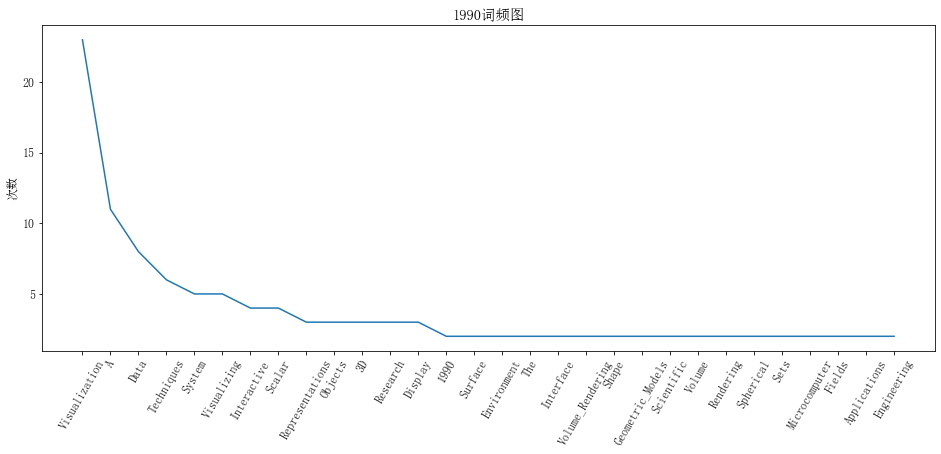

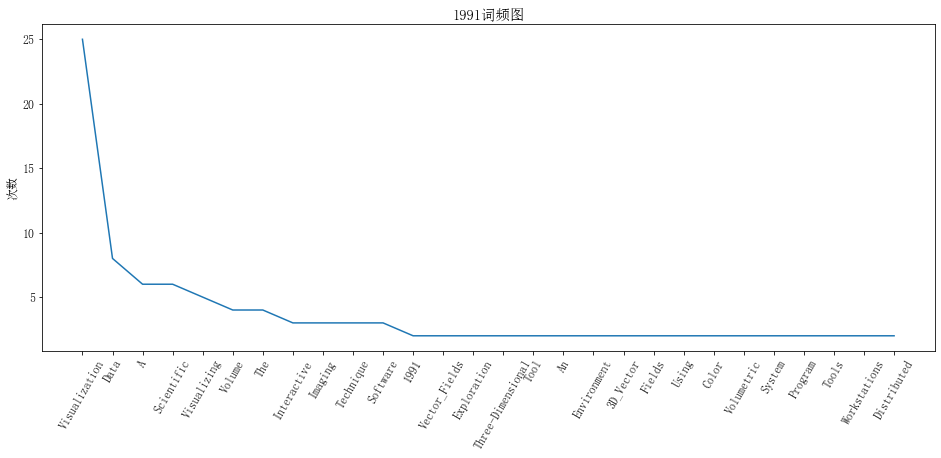

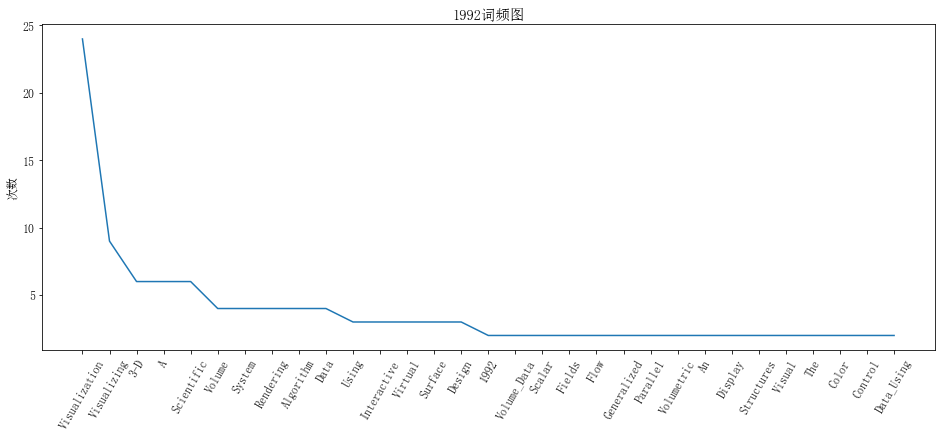

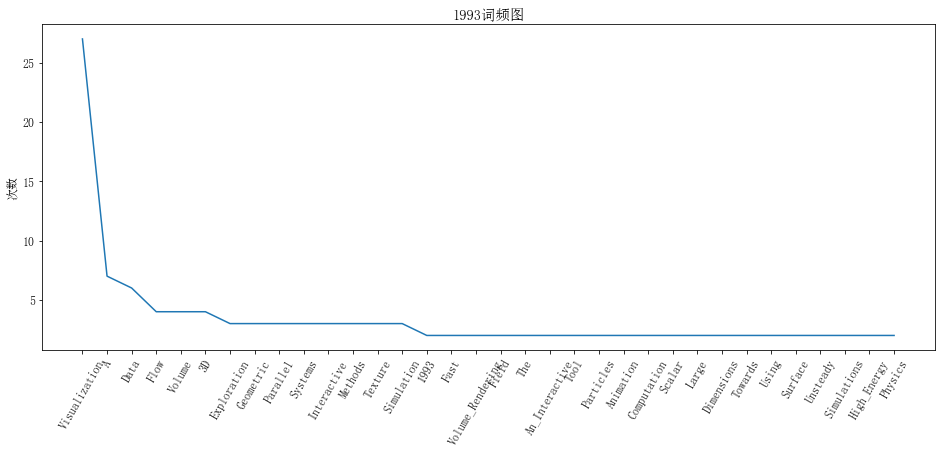

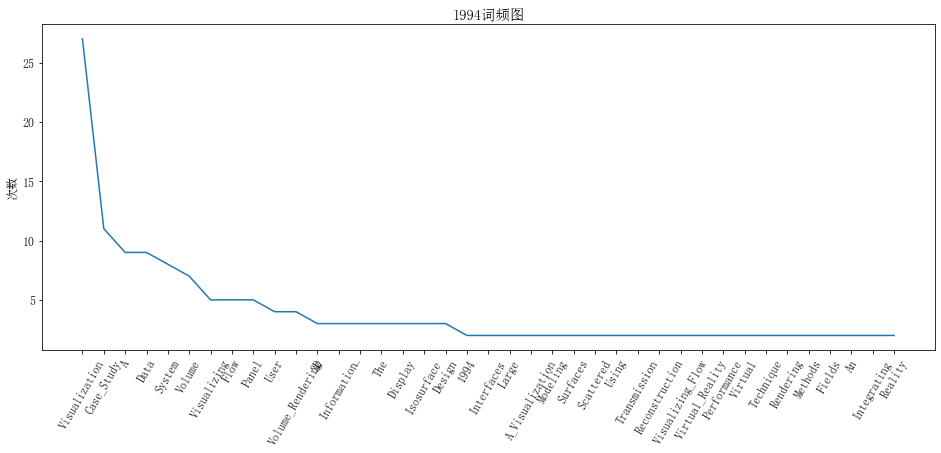

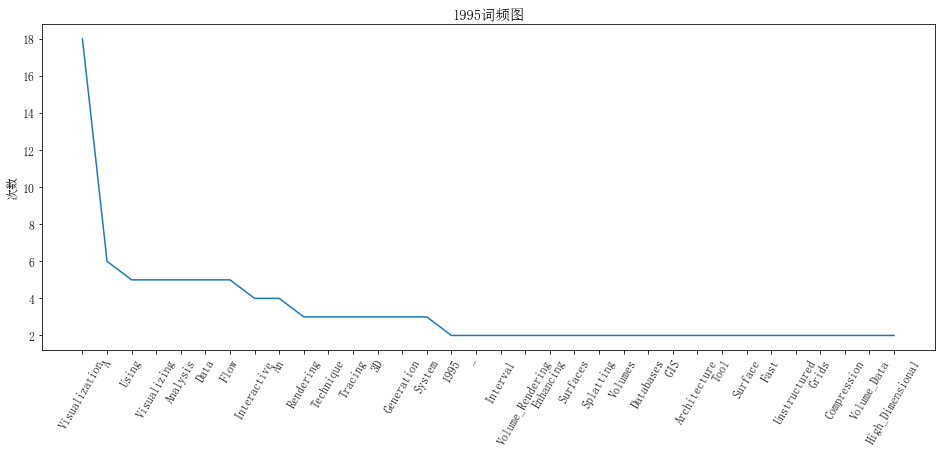

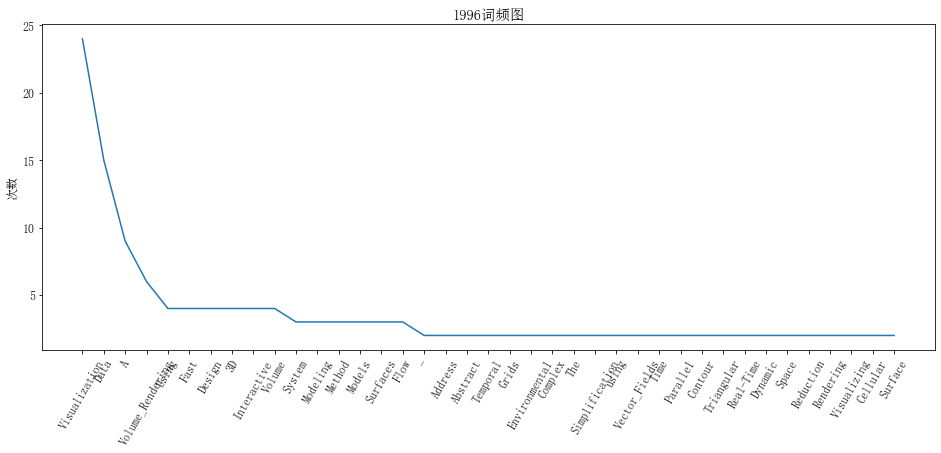

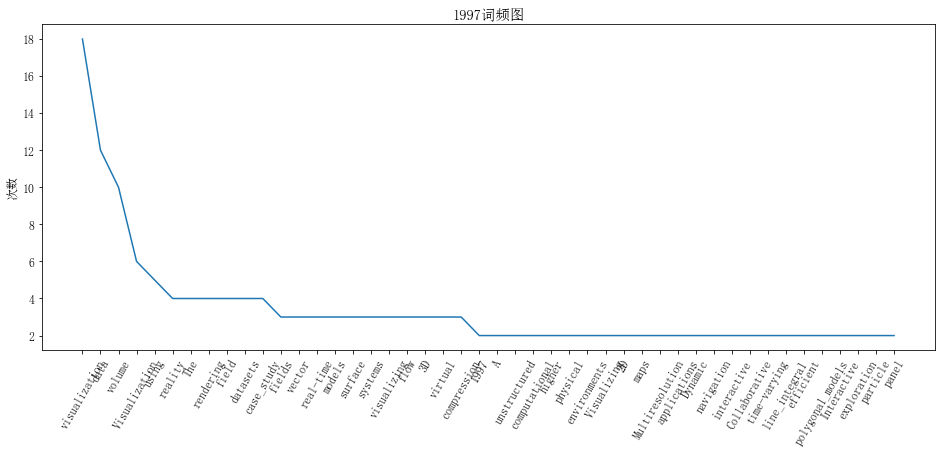

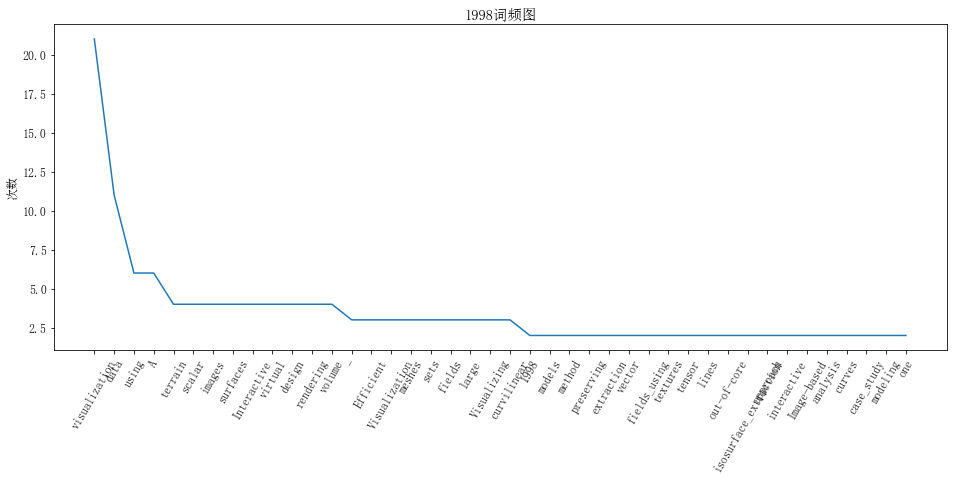

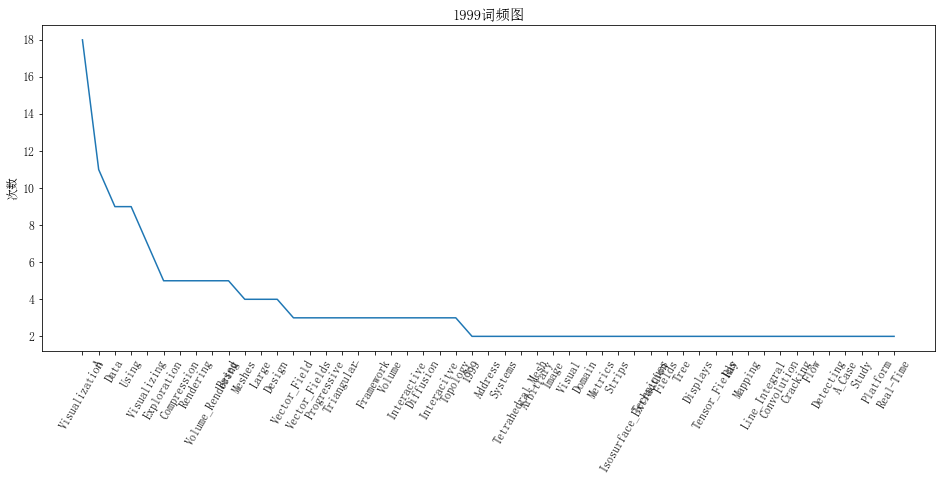

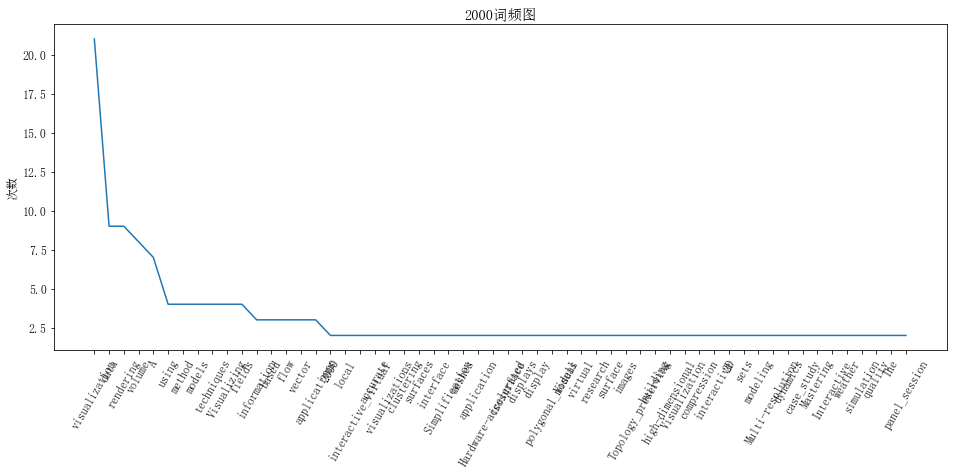

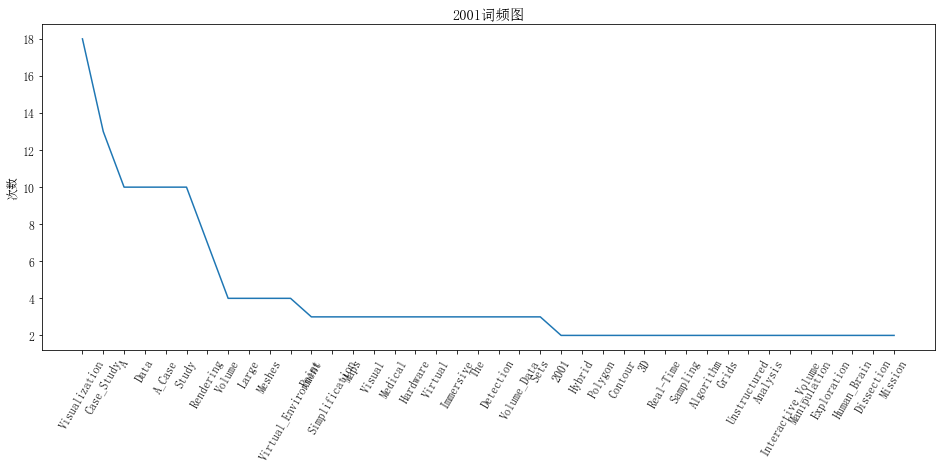

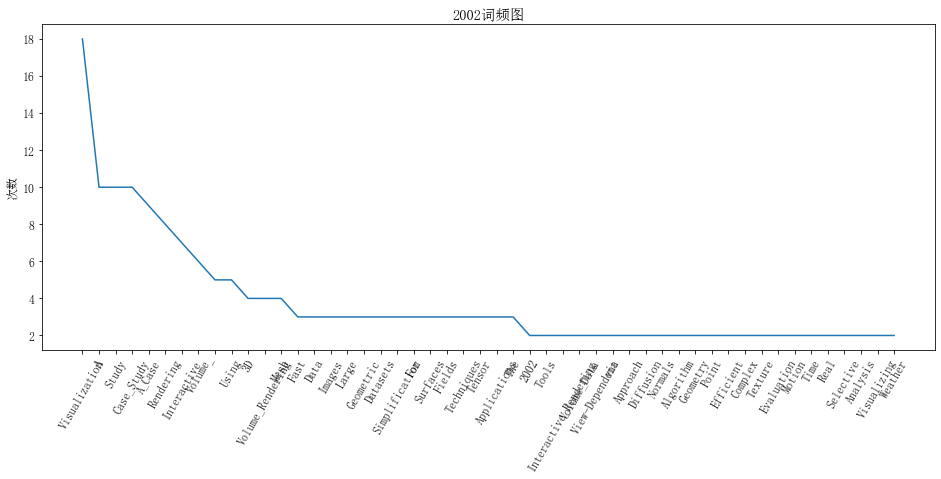

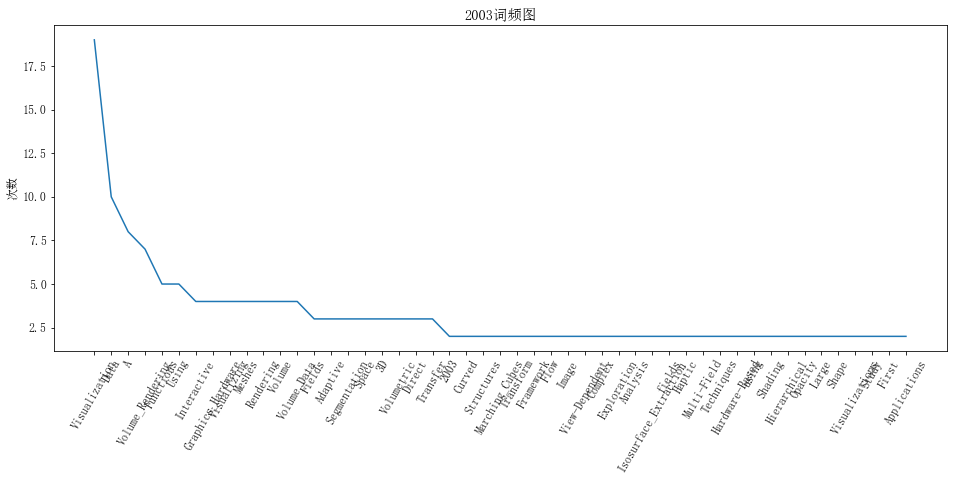

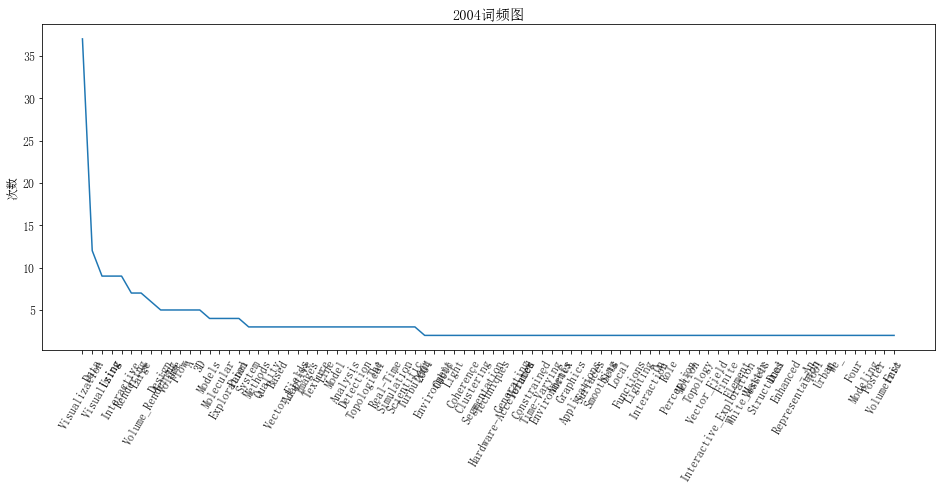

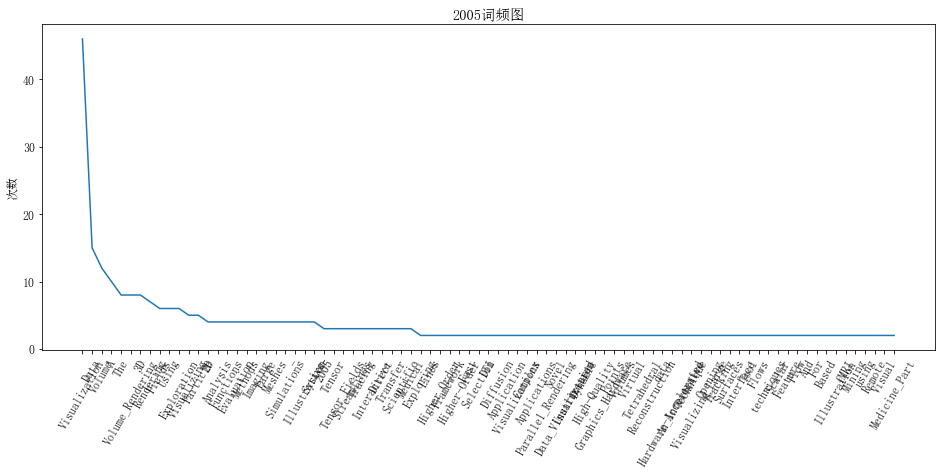

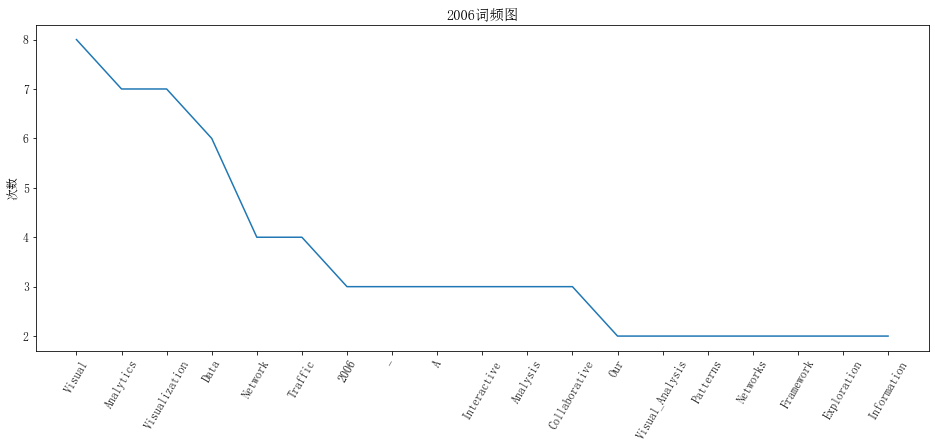

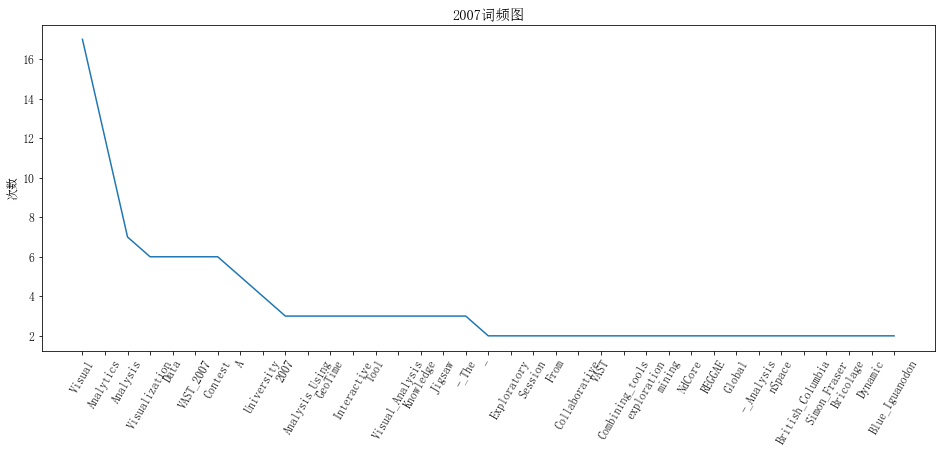

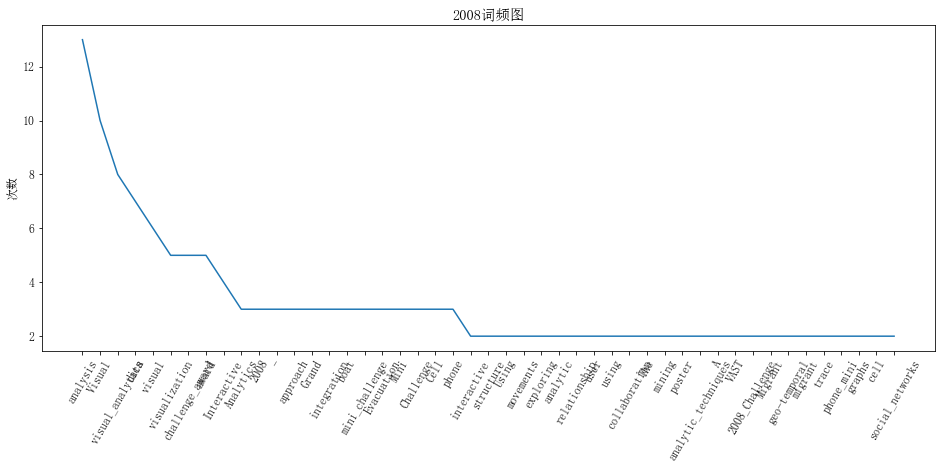

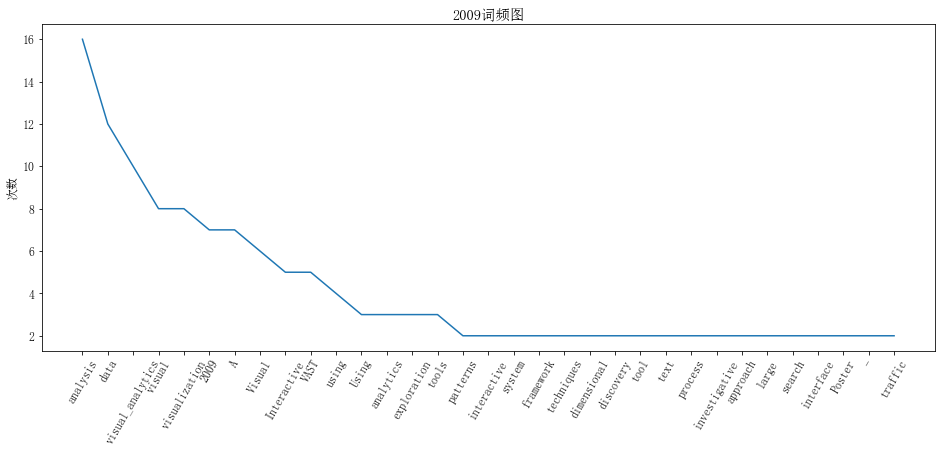

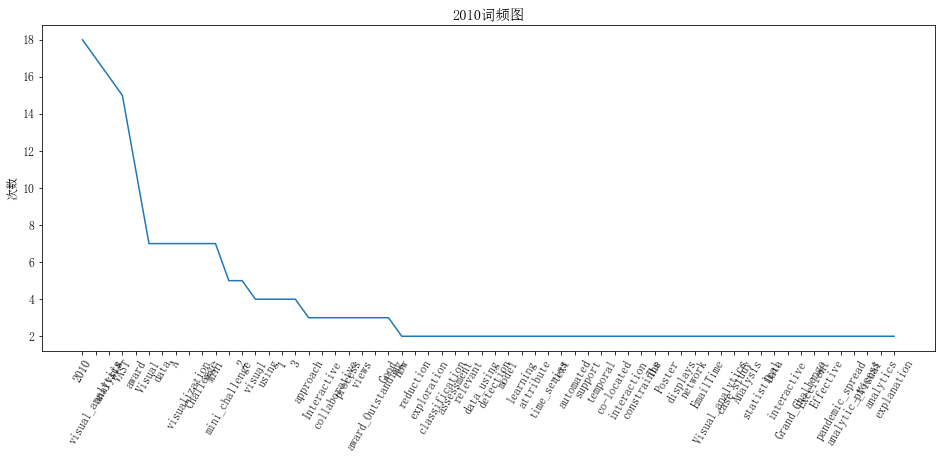

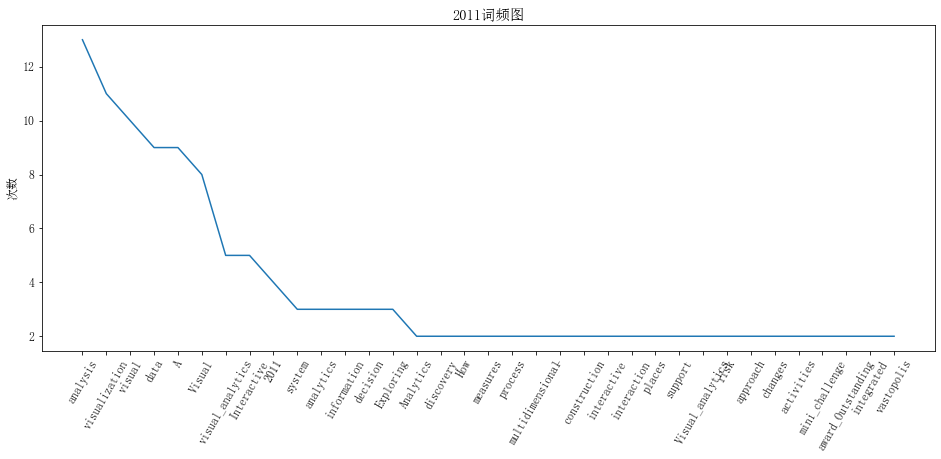

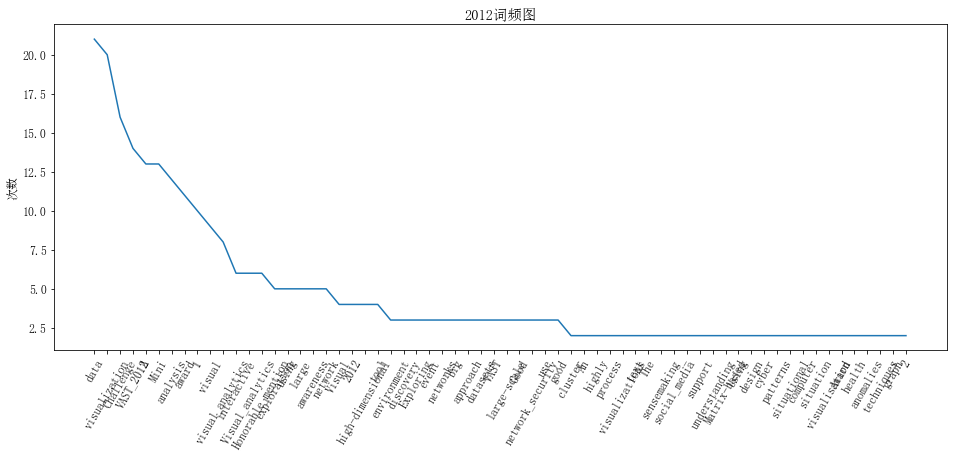

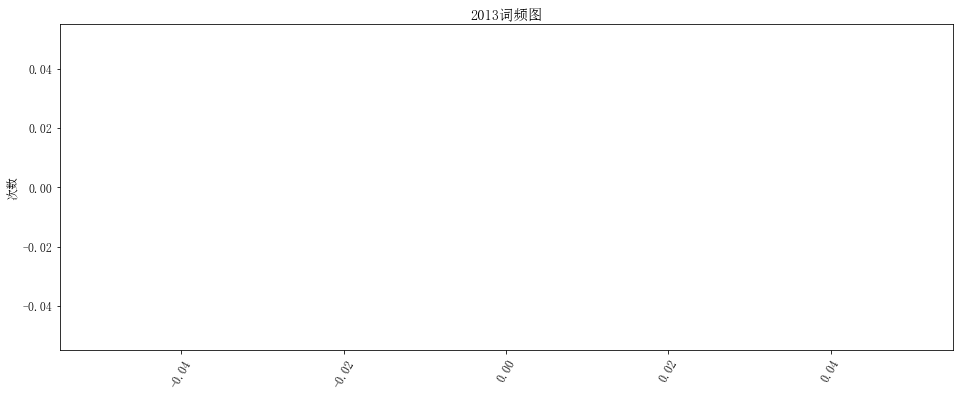

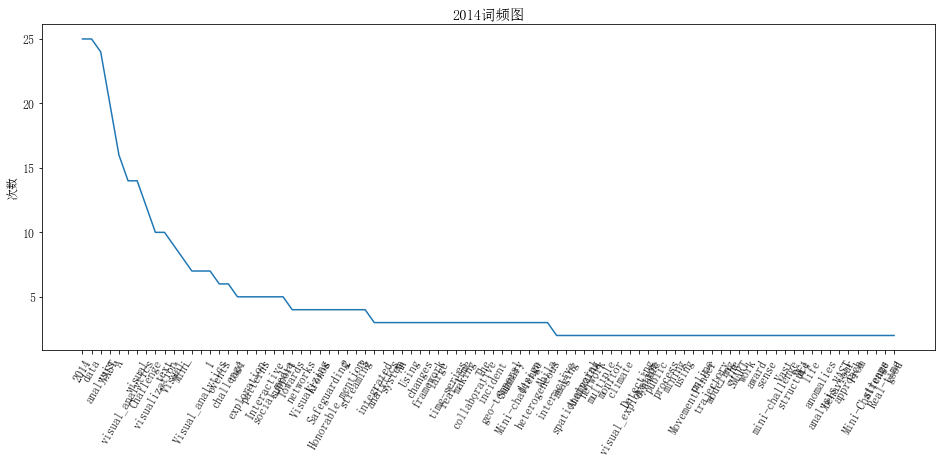

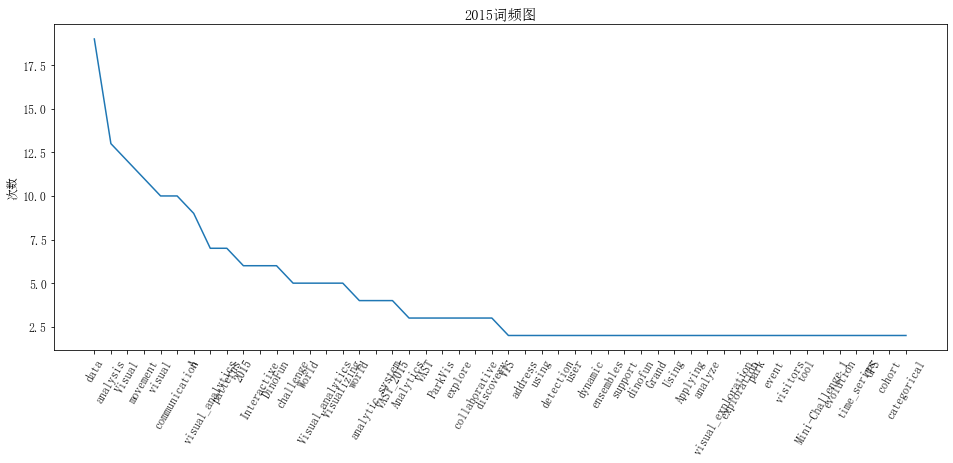

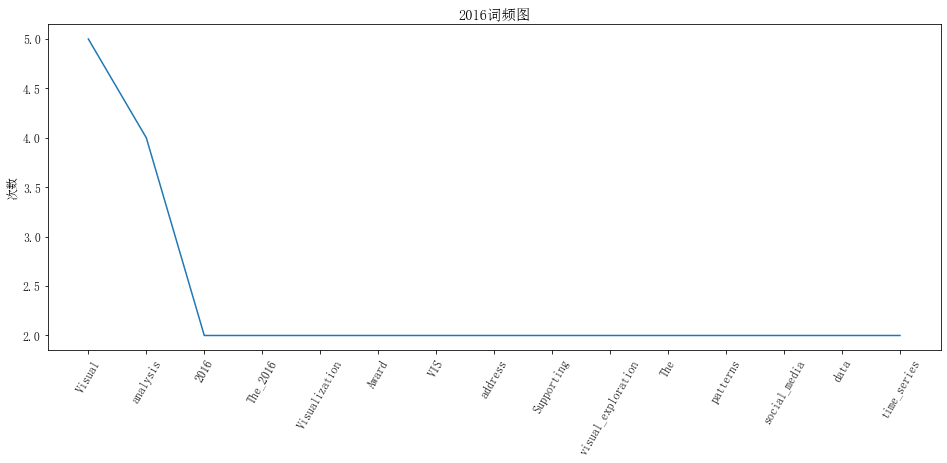

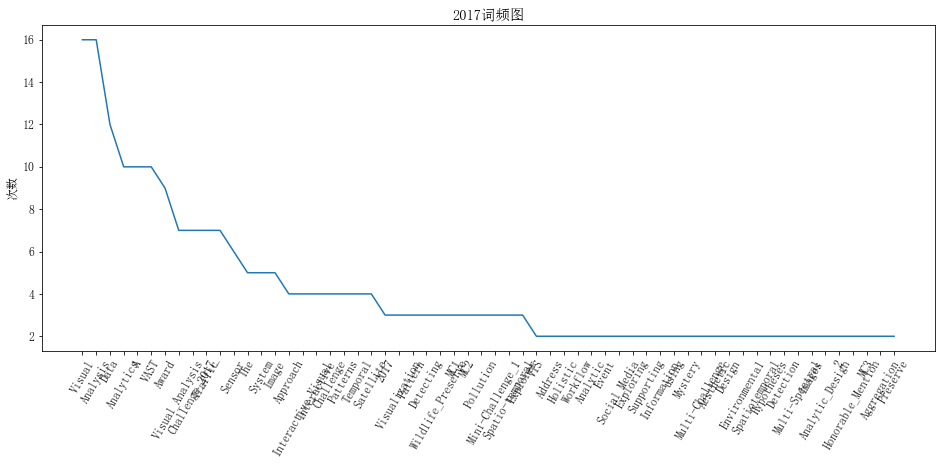

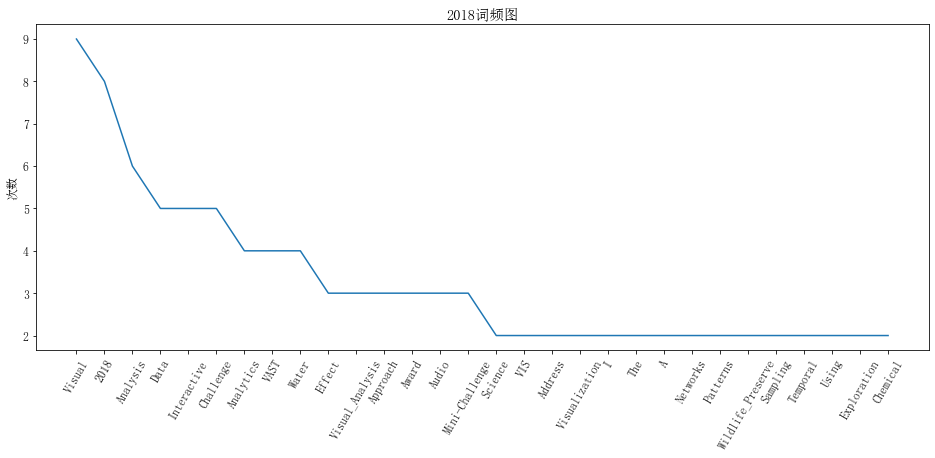

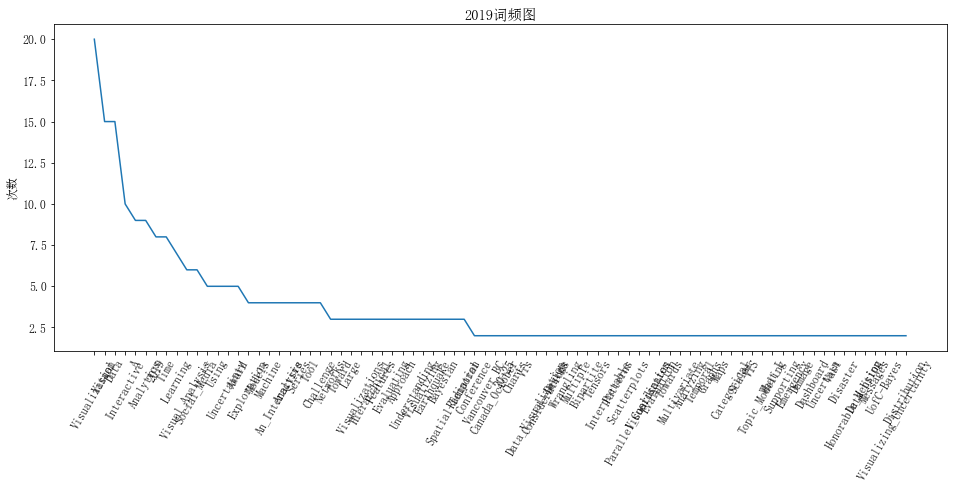

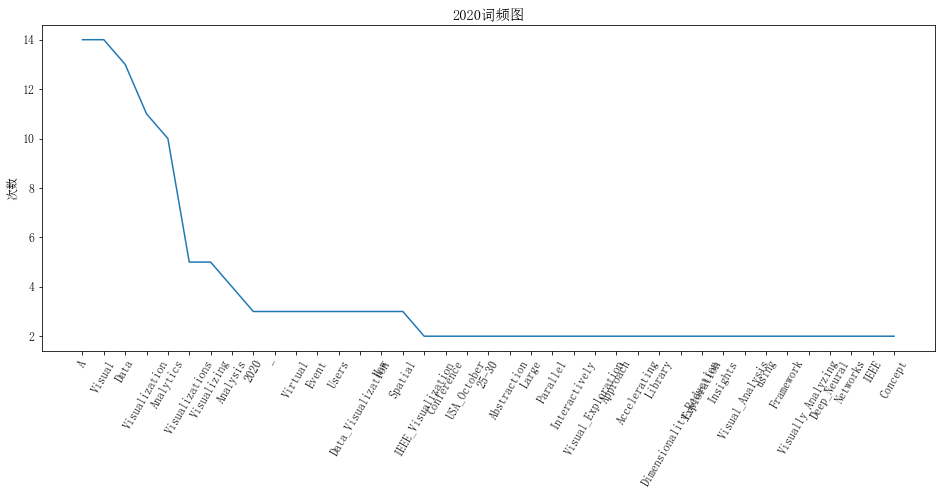

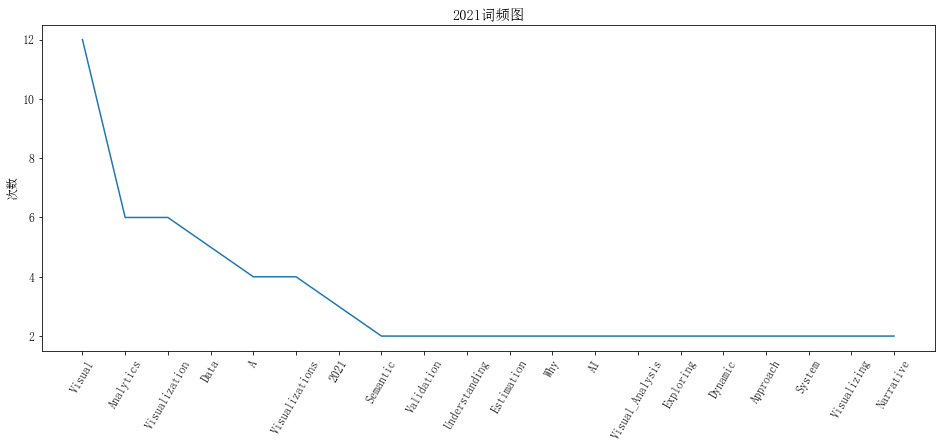

In [72]:
startYear = 1990 # 输出太多，所以减小点
# startYear = 2020
endYear = 2021
for year in range(startYear, endYear + 1):
    pltFig(year, 1)   # 分年查看词频大于1的所有词的词频情况

## 5 获取全年词频，绘图，观察

Visualization              397
A                          234
Data                       181
Visual                     170
data                       137
visualization              124
analysis                   117
Interactive                111
Visualizing                 95
Using                       77
Analytics                   71
Analysis                    69
visual_analytics            69
-                           68
VAST                        67
visual                      64
Volume                      62
The                         59
Rendering                   53
Challenge                   53
Volume_Rendering            51
3D                          50
using                       48
System                      47
Large                       39
Case_Study                  38
Flow                        36
Exploration                 36
Design                      34
Mini                        33
Study                       32
IEEE                        31
An      

Text(0.5, 1.0, '全32年词频图')

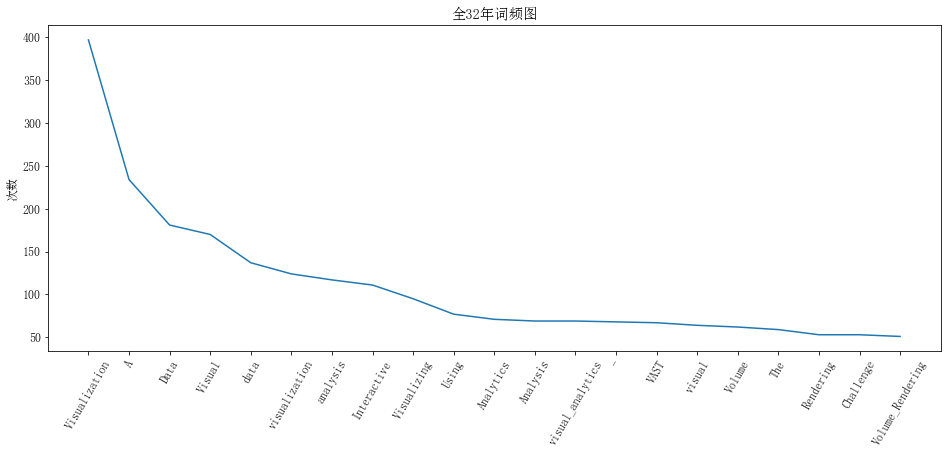

In [74]:
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 12,# 相当于小四大小
            "mathtext.fontset": 'stix',#matplotlib渲染数学字体时使用的字体，和Times New Roman差别不大
            "font.serif": ['SimSun'],#宋体
            'axes.unicode_minus': False # 处理负号，即-号
         }
rcParams.update(config)

# 全年词频
DictByYear = load_variable1('IEEEV_wordFreqDict.txt')
allYearDict = dict()
for year in range(1990, 2022):
    curWords = DictByYear[year][2]
    
    for k, v in curWords.items():
        allYearDict[k] = allYearDict.get(k, 0) + v
        
# print(allYearDict.items())

items = list(allYearDict.items())  # 转换为list
length = len(items)

# print("items.len = " + str(len(items)))  # ●2 不一样的词的个数
items.sort(key=lambda x: x[1], reverse=True)  # 按照词频排序


wordcloudDic = dict()  # ●3 存放前k个词 & 词频

top_k = 1000

for i in range(top_k):
    word, count = items[i]
    wordcloudDic[word] = count
    if count > 10:
        print("{0:<20}{1:>10}".format(word, count))


# 只画出词频大于50的词，看看情况
plt_dic = dict()
for k, v in wordcloudDic.items():
    if v > 50:
        plt_dic[k] = v
# ------------------------------------------ 词频图
x1 = list(plt_dic.keys())
y1 = list(plt_dic.values())
plt.figure(figsize=(16, 6))
plt.plot(x1, y1)
plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('次数')
plt.title(f'全{endYear-startYear + 1}年词频图')

## 6
### 下面获取每年的文章数和文章标题 & 存储下来
形如：`{1995: [文章数、文章标题], 1996: [文章数、文章标题], }`

In [63]:
def saveTitleByYear(targetCol, year, targetField, titleDict):
    
    titleDict[year] = list()
    
    exec(targetCol + " = db_IEEEVIS_28years['" + targetCol+ "']")
    loc = locals()
    
    Titles = {}  # key(词汇)，value(词频数)

    queryCondition = {"year": year}
    exec("recs = " + targetCol + ".find(queryCondition)")
    
    tempCnt_Titles = 0
    
    currentContent = list()
    for cT in loc['recs']:
        currentContent.append(cT.get(targetField))
        tempCnt_Titles = len(currentContent)  # 存放当年的总文章数

    titleDict[year].append(tempCnt_Titles)
    titleDict[year].append(currentContent)

In [64]:
targetCol = 'col_IEEEVIS_28years'
titleDict = dict()

for year in range(1990, 2021 + 1):
    saveTitleByYear(targetCol, year, 'title', titleDict)
    

In [65]:
save_variable1(titleDict, 'IEEEV_resTitles_withType.txt')

'IEEEV_resTitles_withType.txt'

In [66]:
save_variable2(str(titleDict), 'IEEEV_resTitles_withoutType.txt')

'IEEEV_resTitles_withoutType.txt'

In [67]:
titlesDict = load_variable1('IEEEV_resTitles_withType.txt')

In [69]:
for year in range(1990, 2021 + 1):
    print(f"{year}的文章标题为：")
    print("-----------------------")
    for temp in titlesDict[year][1]:
        print(temp)
    print("============================================================")

1995的文章标题为：
-----------------------
6th IEEE Visualization Conference, IEEE Vis 1995, Atlanta, GA, USA, October 29 - November 3, 1995, Proceedings.
Interval Set: A Volume Rendering Technique Generalizing Isosurface Extraction.
Interactive Maximum Projection Volume Rendering.
Interactive Realism for Visualization Using Ray Tracing.
A Hardware Acceleration Method for Volumetric Ray Tracing.
Defining, Computing, and Visualizing Molecular Interfaces.
Visualization of Biological Sequence Similarity Search Results.
Enhancing Transparent Skin Surfaces with Ridge and Valley Lines.
Splatting of Curvilinear Volumes.
On Enhancing the Speed of Splatting with Indexing.
IFS Fractal Interpolation for 2D and 3D Visualization.
Automated Generation of Visual Simulation Databases Using Remote Sensing and GIS.
Virtual GIS: A Real-Time 3D Geographic Information System.
An Architecture for Retaining and Analyzing Visual Explorations of Databases.
An Illustrated Analysis of Sonification for Scientific Visual

VIS keynote address: An Evolving Visual Language.
VIS capstone address: Architectures Physical and Digital.
Wavelet-based visualization of time-varying data on graphs.
Mixed-initiative visual analytics using task-driven recommendations.
Integrating predictive analytics into a spatiotemporal epidemic simulation.
Collaborative visual analysis with RCloud.
Four considerations for supporting visual analysis in display ecologies.
Supporting activity recognition by visual analytics.
iVizTRANS: Interactive visual learning for home and work place detection from massive public transportation data.
DemographicVis: Analyzing demographic information based on user generated content.
EgoNetCloud: Event-based egocentric dynamic network visualization.
FPSSeer: Visual analysis of game frame rate data.
Comparative visual analysis of vector field ensembles.
Interactive visual steering of hierarchical simulation ensembles.
Urbane: A 3D framework to support data driven decision making in urban development.

每年的文章数（1990~2021）：
55
51
54
56
66
57
73
78
79
75
77
75
79
81
112
135
30
49
47
61
65
60
70
0
108
69
20
55
30
95
71
42


Text(0.5, 1.0, '近32年IEEE VIS & IEEE VAST论文数量图')

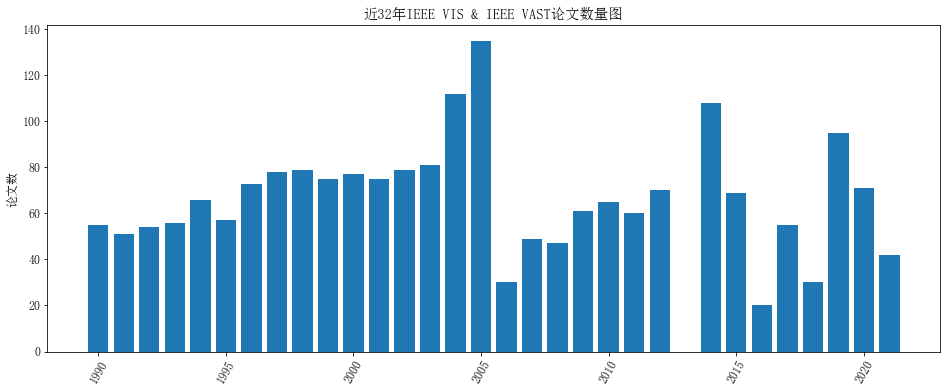

In [73]:
# 分年存储
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import ImageFont

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

year_numbers = dict()
print("每年的文章数（1990~2021）：")
for year in range(1990, 2021 + 1):
    print(titlesDict[year][0])
    year_numbers[year] = titlesDict[year][0]
    
x1 = list(year_numbers.keys())
y1 = list(year_numbers.values())
plt.figure(figsize=(16, 6))
plt.bar(x1, y1)
plt.xticks(rotation=60)  # 设置x轴上的刻度旋转角度
plt.ylabel('论文数')
plt.title(f'近{endYear-startYear + 1}年IEEE VIS & IEEE VAST论文数量图')